# 나이브 방법
- persistent: 앞의 n개의 샘플 값으로 단순 예측 (n=1)
- mean: 앞의 n개의 평균값으로 예측
- median: 앞의 n개 샘플의 중위값으로 예측
- offset: 주기적인 인터벌을 고려하여 샘플링

In [0]:
# peristent (n번째 이전의 훈련 데이터 샘플을 리턴)
def naive_forecast(history, n):
  return history[-n]

In [0]:
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
print(data)
for i in range(1, len(data)+1):
  print(naive_forecast(data, i))

[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
100.0
90.0
80.0
70.0
60.0
50.0
40.0
30.0
20.0
10.0


In [0]:
# mean과 median
# config에 n, type을 지정
from numpy import mean
from numpy import median

def average_forecast(history, config):
    n, avg_type = config
    if avg_type is 'mean':
      return mean(history[-n:])
    return median(history[-n:])

In [0]:
for i in range(1, len(data)+1):
    print(average_forecast(data, (i, 'mean')))

100.0
95.0
90.0
85.0
80.0
75.0
70.0
65.0
60.0
55.0


### 계절 요인(주기성)을 반영

In [0]:
# history: 학습 데이터
def average_forecast(history, config):
  n, offset, avg_type = config
  values = list()
  if offset == 1:
    values = history[-n:]
  else:
    # 데이터 전체 범위를 벗어나는 경우 검출
    if n*offset > len(history):
        raise Exception('Config beyond end of data: %d %d' % (n,offset))
    # offset의 간격으로 n개의 샘플을 취득
    for i in range(1, n+1):
     ix = i * offset
     values.append(history[-ix])
    if avg_type is 'mean': return mean(values)
    return median(values)

In [0]:
data = [10.0, 20.0, 30.0, 10.0, 20.0, 30.0, 10.0, 20.0, 30.0]
print(data)
for i in [1, 2, 3]:
    print(average_forecast(data, (i, 3, 'mean')))

[10.0, 20.0, 30.0, 10.0, 20.0, 30.0, 10.0, 20.0, 30.0]
10.0
10.0
10.0


### 위의 결과는 각각 [10], [10, 10], [10, 10, 10] 의 평균임

## 나이브 방법과 평균 방법을 하나의 함수로 만든다: simple forecast

In [0]:
def simple_forecast(history, config): 
  n, offset, avg_type = config
  if avg_type == 'persist':
    return history[-n]
  values = list()
  if offset == 1:
    values = history[-n:]
  else:
    for i in range(1, n+1):
        if i*offset > len(history):
            continue
        ix = i * offset
        values.append(history[-ix])
#   else:
#     if n*offset > len(history):
#         raise Exception('Config beyond end of data: %d %d' % (n,offset))
#     for i in range(1, n+1):
#       ix = i * offset
#       values.append(history[-ix])

    if avg_type == 'mean': 
      return mean(values)
    return median(values)

## 훈련-검증 데이터 나누기 (시계열)

In [0]:
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]

## 손실함수 선택 (rmse)

In [0]:
# rmse
def measure_rmse(actual, predicted):
  return sqrt(mean_squared_error(actual, predicted))

## walk-forward 검증
- 한 샘플씩 진행하면서 검증 과정 수행

In [0]:
def walk_forward_validation(data, n_test, cfg):
  predictions = list()
  train, test = train_test_split(data, n_test)
  # 초기의 훈련용 입력 데이터
  history = [x for x in train]
  # 테스트 데이터 하나씩 처리
  for i in range(len(test)):
    yhat = simple_forecast(history, cfg)
    # 첫번째 예측값
    predictions.append(yhat)
    # 실제 값(레이블)을 훈련 데이터에 추가(history)
    history.append(test[i])
  error = measure_rmse(test, predictions)
  return error

### 성능 평가

In [0]:
def score_model(data, n_test, cfg):
  result = walk_forward_validation(data, n_test, cfg)
  return (cfg, result)

In [0]:
# 디버그 모드
# def score_model(data, n_test, cfg, debug=False):
#   result = None
#   # 디버그 시에는 경고문 보기
#   if debug:
#     result = walk_forward_validation(data, n_test, cfg)
#   else:
#     try:
#       with catch_warnings():
#         filterwarnings("ignore")
#         result = walk_forward_validation(data, n_test, cfg)
#     except:
#       error = None
#   if result is not None:
#     print(' > Model[%s] %.3f' % (key, result))
#   return (cfg, result)

### 그리드 탐색

In [0]:
# 그리드 탐색
def grid_search(data, cfg_list, n_test):
  scores = None
  scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
  # 없는 결과 삭제
  scores = [r for r in scores if r[1] != None]
  scores.sort(key=lambda x: x[1])
  return scores

In [0]:
# # 그리드 탐색 (병렬처리 경우)
# def grid_search(data, cfg_list, n_test, parallel=True):
#   scores = None
#   if parallel:
#     executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing') 
#     tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list) 
#     scores = executor(tasks)
#   else:
#     scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
#   # 없는 결과 삭제
#   scores = [r for r in scores if r[1] != None]
#   scores.sort(key=lambda tup: tup[1])
#   return scores

## 샘플 하이퍼파라미터 생성 함수
- 계절적 요인은 없는 것으로 가정(offset=1)

In [0]:
def simple_configs(max_length, offsets=[1]):
  configs = list()
  for i in range(1, max_length+1):
    for o in offsets:
      for t in ['persist', 'mean', 'median']:
        cfg = [i, o, t]
        configs.append(cfg)
  return configs

### 전체 코드

In [0]:
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error

def simple_forecast(history, config):
    n, offset, avg_type = config
    if avg_type == 'persist':
        return history[-n]
    values = []
    if offset == 1:
        values = history[-n:]
    else:
        for i in range(1, n+1):
            if i*offset > len(history):
                continue
            ix = i * offset
            values.append(history[-ix])
    if avg_type == 'mean':
        return mean(values)
    return median(values)

# RMSE
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# 훈련-검증 데이터 나누기
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

def walk_forward_validation(data, n_test, cfg):
	predictions = []
	train, test = train_test_split(data, n_test)
	history = [x for x in train]
	for i in range(len(test)):
		yhat = simple_forecast(history, cfg)
		predictions.append(yhat)
		history.append(test[i])
	error = measure_rmse(test, predictions)
	return error


def score_model(data, n_test, cfg):
  result = walk_forward_validation(data, n_test, cfg)
  return (cfg, result)

# 그리드 탐색
def grid_search(data, cfg_list, n_test):
  scores = None
  scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
  scores = [r for r in scores if r[1] != None]
  scores.sort(key=lambda x: x[1])
  return scores

# 하이퍼파라미터 환경 설정 (그리드 탐색용)
def simple_configs(max_length, offsets=[1]):
	configs = list()
    # (n, offset=1, type) 지정
	for i in range(1, max_length+1):
		for o in offsets:
			for t in ['persist', 'mean', 'median']:
				cfg = [i, o, t]
				configs.append(cfg)
	return configs

## 테스트

In [0]:
if __name__ == '__main__':
	# define dataset
	data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
	# data split
	n_test = 4
	# model configs
	max_length = len(data) - n_test
	cfg_list = simple_configs(max_length)
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

done
[1, 1, 'persist'] 10.0
[1, 1, 'mean'] 10.0
[1, 1, 'median'] 10.0


In [0]:
scores[0][0]

[1, 1, 'persist']

## 예제 (트렌드와 계절적요인 없는 경우)
### 1959년 캘리포니아의 여성 출생 숫자 데이터 (일일)

In [0]:
from pandas import read_csv
!curl -L https://bit.ly/2ptubpK -o daily-total-female-births.csv
series = read_csv('daily-total-female-births.csv', header=0, index_col=0) 
print(series.shape)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   158  100   158    0     0   1950      0 --:--:-- --:--:-- --:--:--  1950
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  5855  100  5855    0     0   5327      0  0:00:01  0:00:01 --:--:--  5327
(365, 1)


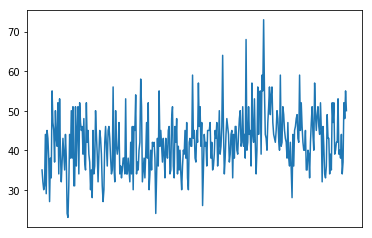

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(series)
plt.xticks([])
plt.show()

In [0]:
# if __name__ == '__main__':
series = read_csv('daily-total-female-births.csv', header=0, index_col=0) 
data = series.values
n_test = 165
max_length = len(data) - n_test
cfg_list = simple_configs(max_length)
scores = grid_search(data, cfg_list, n_test)
# 상위 3개 보기
for cfg, error in scores[:3]:
    print(cfg, error)

[22, 1, 'mean'] 6.930411499775709
[23, 1, 'mean'] 6.932293117115201
[21, 1, 'mean'] 6.951918385845375


In [0]:
config_list = [[22,1,'mean'],[3,1,'mean'], [1,1,'persist']]
[score_model(data, n_test, cfg) for cfg in config_list]

[([22, 1, 'mean'], 6.930411499775709),
 ([3, 1, 'mean'], 7.51819342150974),
 ([1, 1, 'persist'], 8.721620644505622)]

In [0]:
num_config = len(config_list)
train, test = train_test_split(data, n_test)
history = [x for x in train]
predictions = []

for i in range(num_config):
    pred = []
    for sample in range(len(test)):
        yhat = simple_forecast(history, config_list[i])
        pred.append(yhat)
        history.append(test[sample])
    predictions.append(pred)

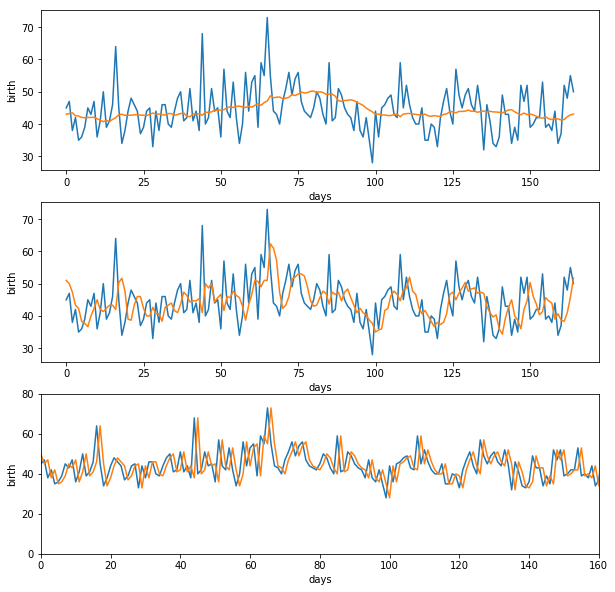

In [0]:
fig, ax = plt.subplots(num_config,figsize=(10,10))
plt.xlim(0,160)
plt.ylim(0,80)
for i in range(num_config):
    ax[i].plot(test)
    ax[i].plot(predictions[i])
for ax in ax.flat:
    ax.set(xlabel='days', ylabel='birth')

## 예제
- 3년간 샴푸 월별 세일 데이터
- 36개 데이터 중 24개를 훈련용으로 12개를 테스트용으로 사용
- 트렌드가 있는 경우

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   154  100   154    0     0   4967      0 --:--:-- --:--:-- --:--:--  4967
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   483  100   483    0     0    581      0 --:--:-- --:--:-- --:--:--  1412
(36, 1)


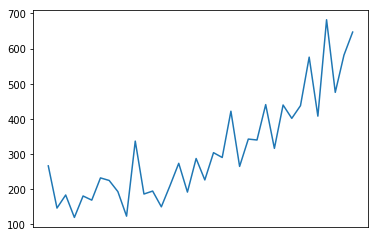

In [0]:
# load
!curl -L https://bit.ly/2JwLduv -o monthly-shampoo-sales.csv
series = read_csv('monthly-shampoo-sales.csv', header=0, index_col=0) 
# summarize shape
print(series.shape)
# plot
plt.plot(series)
plt.xticks([])
plt.show()

In [0]:
# if __name__ == '__main__':
# load dataset
series = read_csv('monthly-shampoo-sales.csv', header=0, index_col=0) 
data = series.values
# data split
n_test = 12
# model configs
max_length = len(data) - n_test
cfg_list = simple_configs(max_length)
# grid search
scores = grid_search(data, cfg_list, n_test)
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

[2, 1, 'persist'] 95.69454007413378
[2, 1, 'mean'] 96.01140340258198
[2, 1, 'median'] 96.01140340258198


- 바로 앞의 샘플이 아니라, 두 단계 이전 값으로 예측하는 경우가 가장 성능이 좋았다.

## 예제
- 1920~1939 년 사이의 영국 노팅험 성의 월 평균 기온 데이터
- 계절적 요인이 강하게 나타난다,

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   150  100   150    0     0   4838      0 --:--:-- --:--:-- --:--:--  5000
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  3861  100  3861    0     0   4387      0 --:--:-- --:--:-- --:--:--  4387
(240, 1)


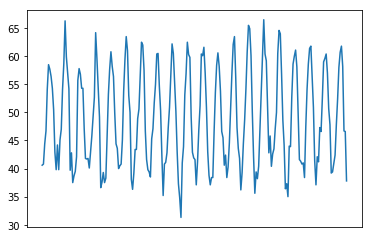

In [0]:
!curl -L https://bit.ly/33ZSevg -o monthly-mean-temp.csv
series = read_csv('monthly-mean-temp.csv', header=0, index_col=0) # summarize shape
print(series.shape)
# plot
plt.plot(series)
plt.xticks([])
plt.show()

In [0]:
# trim dataset to 5 years
data = data[-(5*12):]

In [0]:
# if __name__ == '__main__':
# define dataset
series = read_csv('monthly-mean-temp.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
  # model configs
max_length = len(data) - n_test
cfg_list = simple_configs(max_length, offsets=[1,2, 3, 6, 12, 24]) 
# grid search
scores = grid_search(data, cfg_list, n_test) 
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

done
[4, 12, 'mean'] 1.5015616870445234
[4, 24, 'mean'] 1.572020992226248
[8, 12, 'mean'] 1.5794579766489512


## 예제
- 월별 자동차 판매 데이터 (퀘벡), 1960-1968
- 트렌드와 계절적 요인이 모두 존재

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   150  100   150    0     0   4687      0 --:--:-- --:--:-- --:--:--  4687
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1838  100  1838    0     0   2167      0 --:--:-- --:--:-- --:--:-- 13924
(108, 1)


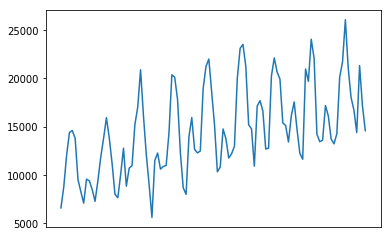

In [0]:
!curl -L https://bit.ly/32JCNXY -o monthly-car-sales.csv
series = read_csv('monthly-car-sales.csv', header=0, index_col=0) 
# summarize shape
print(series.shape)
# plot
plt.plot(series)
plt.xticks([])
plt.show()

In [0]:
# if __name__ == '__main__':
# define dataset
series = read_csv('monthly-car-sales.csv', header=0, index_col=0) 
data = series.values
# data split
n_test = 12
# model configs
max_length = len(data) - n_test
cfg_list = simple_configs(max_length, offsets=[1,2, 3, 4, 6, 12])
# grid search
scores = grid_search(data, cfg_list, n_test) 
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

done
[3, 12, 'median'] 1841.1559321976688
[3, 12, 'mean'] 2115.198495632485
[4, 12, 'median'] 2184.37708988932


# ETS  모델